# Experiment 14: Model building using 1600 observations (Surface Elevation)

## Imports

In [11]:
%matplotlib notebook

In [12]:
# Import packages:
import mikeio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import sys
import pickle as pkl
import dill
import pandas as pd

sys.path.append("../")
plt.style.use("seaborn-v0_8-whitegrid")

from Scripts import my_functions as mf, my_models as mm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LinearRegression, Ridge

from IPython.display import HTML
from tqdm import tqdm

## Setup

In [13]:
%%time 

# Auxilliary variable:
compute = 1

# Try to load results from earlier runs:
if 1:
    
    # Load combined data if available:
    if os.path.exists("../../Data/my_data/data.pkl"):
        
        # Load dataframe:
        with open("../../Data/my_data/data.pkl", "rb") as f:
            df_full = dill.load(f)
            
        # Change compute to 0:
        compute = 0
        
print(f"compute = {compute}")  

compute = 0
Wall time: 9.4 s


In [4]:
if 0:
    with open("../../Data/my_data/data.pkl", "wb") as f:
        dill.dump(df_full.iloc[48:], f, -1)
        
df_full.shape

(18143, 54004)

In [5]:
%%time

# Compute the combined data if not available: (~ 10 min)
if compute:
    
    # Define paths:
    path_area = "../../Data/DHI_yr_sim/Area.dfsu"
    path_wind = "../../Data/DHI_yr_sim/HD_OERESUND_CREA6_1997_v2.m21fm - Result Files/wind.dfs0"
    
    path_bc_north = "../../Data/DUMP/waterlevel_bc/waterlevel_north.dfs1"
    path_bc_south = "../../Data/DUMP/waterlevel_bc/waterlevel_south.dfs1"
    
    # Extract time:
    time_data = mikeio.open(path_area).time
    
    
    print("Loading data...")
    
    # Load files:
    zuv_data  = mikeio.read(path_area,
                           time=time_data)
    wind_data = mikeio.read(path_wind,
                           time=time_data)

    bc_north_data = mikeio.read(path_bc_north,
                               time=time_data)
    bc_south_data = mikeio.read(path_bc_south,
                               time=time_data)
    
    
    print("Extracting values...")
    
    # Extract values of surface elevation, u-velocity and v-velocity from zuv_data:
    z_vals = zuv_data["Surface elevation"].values
    u_vals = zuv_data["U velocity"].values
    v_vals = zuv_data["V velocity"].values

    # Extract values of u-velocity and v-velocity from wind_data:
    wu_vals = np.concatenate([wind_data[i].values.reshape(-1,1) for i in range(25)], axis=1)
    wv_vals = np.concatenate([wind_data[i].values.reshape(-1,1) for i in range(25, 50)], axis=1)

    # Extract values of bc_north_data and bc_south_data:
    bcn_vals = bc_north_data["North"].values
    bcs_vals = bc_south_data["South"].values
    
    
    print("Creating dataframes...")
    
    # Create dataframes:
    df_z = pd.DataFrame(z_vals).add_prefix("z_")
    df_u = pd.DataFrame(u_vals).add_prefix("u_")
    df_v = pd.DataFrame(v_vals).add_prefix("v_")
    
    df_wu = pd.DataFrame(wu_vals).add_prefix("wu_")
    df_wv = pd.DataFrame(wv_vals).add_prefix("wv_")

    df_bcn = pd.DataFrame(bcn_vals).add_prefix("bcn_")
    df_bcs = pd.DataFrame(bcs_vals).add_prefix("bcs_")
    
    
    print("Combining dataframes...")
    
    # Combine everything:
    df_full = pd.concat([df_z, df_u, df_v, 
                         df_bcn, df_bcs, 
                         df_wu, df_wv], axis=1)
    
    
    print("Setting indices...")
    
    # Set datetime as index:
    df_full.set_index(time_data)
    
    
    print("Discarding first 48 observations...")
    
    df_full = df_full.iloc[48:]
    
    
    print("Saving data...")
    
    with open("../../Data/my_data/data.pkl", "wb") as f:
        pkl.dump(df_full, f)
    

Wall time: 0 ns


In [6]:
df = df_full.iloc[:1600, :]
print(df.shape)

(1600, 54004)


## Create models and test models:

In [7]:
import warnings
warnings.filterwarnings("ignore")
M = mm.MyModels(df, scaler="standard", latent_space="pca")

Init was run.


### Baseline models:

In [8]:
# Create both baseline models:
baseline_models = [
    M.BaselineModel(var="z", model_type="Collective"),
    M.BaselineModel(var="z", model_type="Coordinate")
]

# Run models:
for i, model in enumerate(baseline_models):
        
        # Run model:
        print(f"Running model: {model.name}")
        model.fit(n_train=0.5).predict().del_data()
        print(model.error_metrics)
        print("\n")
        
        # Save model:
        with open(f"../Data_Results/Models/Baseline_{i}", "wb") as f:
            dill.dump(model, f, -1)
        
        
        

Running model: Collective Mean


100%|████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:01<00:00, 1484.35it/s]


   Mean RMSE   Mean ME  Mean MAE       Min Err   Max Err
0   0.186327 -0.023536   0.14455  5.587935e-09  0.955346


Running model: Coordinate Mean


100%|████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:01<00:00, 1281.74it/s]


   Mean RMSE   Mean ME  Mean MAE       Min Err   Max Err
0    0.19132 -0.023536  0.150062  3.725290e-09  1.007261




### Reconstruction models:

In [9]:
# Create reconstruction model:
recon_models = [
    M.ReconModel(var="z", latent_dim=1),
    M.ReconModel(var="z", latent_dim=16),
    M.ReconModel(var="z", latent_dim=100)
]


# Run models:
for i, model in enumerate(recon_models):
    if not model.model_tested:
        print(f"Running model: {model.name}")
        model.fit(n_train=0.5).predict().del_data()
        print(model.error_metrics)
        print("\n")
        
        # Save model:
        with open(f"../Data_Results/Models/Recon_{i}", "wb") as f:
            dill.dump(model, f, -1)

Running model: scale: std, latent: pca(1)-Recon
   Mean RMSE   Mean ME  Mean MAE       Min Err   Max Err
0    0.10816 -0.011583  0.079367  1.454182e-09  0.869935


Running model: scale: std, latent: pca(16)-Recon
   Mean RMSE   Mean ME  Mean MAE       Min Err   Max Err
0   0.002119 -0.000024  0.001642  1.301460e-11  0.092647


Running model: scale: std, latent: pca(100)-Recon
   Mean RMSE   Mean ME  Mean MAE       Min Err  Max Err
0   0.000486 -0.000001  0.000376  2.724876e-12   0.0287




### Best linear model (Found previously)

In [10]:
# Setup best linear model:
linear_model = M.RegressionModel(regressor="linear",
                  var="z", 
                  wind=False, 
                  boundary=True,
                  state_lag=1,
                  extra_lag=2,
                  extra_lead=2,
                  latent_dim=16)

# Run model:
linear_model.fit(n_train=0.5).predict()

100%|█████████████████████████████████████████████████████████████████████████████| 1597/1597 [00:12<00:00, 129.17it/s]


### XGBoost regression model:

In [14]:
# Bestmodel: 132	linear	z	16	False	True	1	2	2	0.013911
xgb_model = M.RegressionModel(regressor="XGBoost",
                  var="z", 
                  wind=False, 
                  boundary=True,
                  state_lag=2,
                  extra_lag=2,
                  extra_lead=2,
                  latent_dim=16)

xgb_model.fit(n_train=0.5).predict()

100%|██████████████████████████████████████████████████████████████████████████████| 1597/1597 [01:14<00:00, 21.53it/s]


In [21]:
print(xgb_model.name, "\n", xgb_model.error_metrics[["Mean RMSE", "Mean Train RMSE", "Mean Test RMSE"]])
print(linear_model.error_metrics[["Mean RMSE", "Mean Train RMSE", "Mean Test RMSE"]])

scale: std, latent: pca(16), XGBoost([z, bcn, bcs])->([z]), state_lag: 2, extra_lag: 2, extra_lead: 2 
    Mean RMSE  Mean Train RMSE  Mean Test RMSE
0   0.123684         0.074428        0.158046
   Mean RMSE  Mean Train RMSE  Mean Test RMSE
0   0.013826         0.010707        0.016295


### 1D-PCA SINDy regression model (WIP)

(x0)[k+1] = -0.443 1 + 0.987 x0[k]


<IPython.core.display.Javascript object>


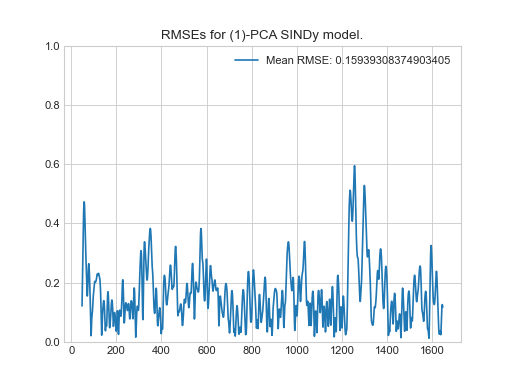

(x0)[k+1] = -0.443 1 + 0.987 x0[k]
(x1)[k+1] = 0.995 x1[k]


<IPython.core.display.Javascript object>


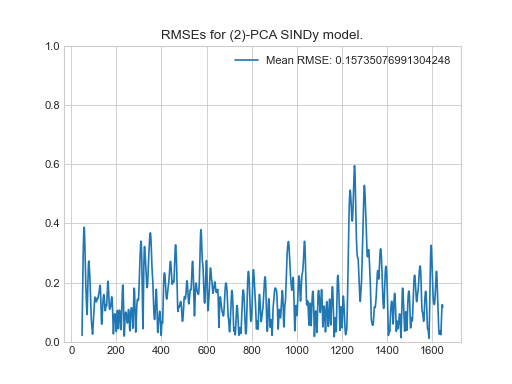

In [13]:
import pysindy as ps

for l_dim in range(1,2):
    m_test = M.ReconModel("z", l_dim)
    d_test, _ = m_test.scale_n_proj("forward", m_test.input_data)
    
    n_train = len(d_test) // 2
    
    d_test_train = d_test.iloc[:n_train]

    optim = ps.STLSQ(threshold=0.20, alpha=1)
#    optim=ps.STLSQ(threshold=0.1, alpha=100)
    m = ps.SINDy(discrete_time=True, 
                 optimizer=optim, t_default=1)

    m.fit(x=d_test_train)

    m.print()

    d_test_sim_tmp = m.simulate(d_test_train.iloc[0, :], t=len(d_test))

    d_test_sim = d_test.copy()
    d_test_sim.values[:] = d_test_sim_tmp

    d_sim, _ = m_test.scale_n_proj("inverse", d_test_sim)

    rmses = mf.rmse(m_test.input_data, d_sim, axis=1)

    plt.figure()
    plt.title(f"RMSEs for ({l_dim})-PCA SINDy model.")
    plt.plot(rmses, label=f"Mean RMSE: {rmses.mean()}")
    plt.plot(rmses*1.1, alpha=0)
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

### DMDc regression model

In [10]:
#def DMDc(X=None, Xprime=None, r, X_c, p):

# Following this: https://arxiv.org/pdf/1409.6358.pdf
if 1:
    
    n_samples = 800
    data = mm.Storage().data["z"]
    
    data = data.iloc[:n_samples]
    
    X_prime = data.iloc[1:].values
    X = data.iloc[:-1].values
    
    bcn = mm.Storage.data["bcn"]
    bcs = mm.Storage.data["bcs"]
    wu = mm.Storage.data["wu"]
    wv = mm.Storage.data["wv"]
    
    n = data.shape[1]
    r = 16
    p = 30
    
    #print(bcn, bcs, wu, wv)
    
    X_c = pd.concat([bcn, bcs], axis=1).iloc[:n_samples].iloc[1:].values
    
    # Step 0: Flip matrices (Columns=Snapshots)
    X_prime = X_prime.T
    X = X.T
    X_c = X_c.T
        
    # Step 1: Construct Omega:
    Omega = np.concatenate([X, X_c], axis=0)
    
    # Step 2: Compute the (tilde)-SVD of Omega
    U_tilde, S_tilde, VT_tilde = np.linalg.svd(Omega, full_matrices=0)
    
    S_tilde_org = S_tilde
    
    # Step 2.1: Truncate with value p (> r):
    U_tilde = U_tilde[:, :p]
    S_tilde = np.diag(S_tilde[:p])
    VT_tilde = VT_tilde[:p, :]
    
    # Step 2.2: Split U_tilde into 2:
    U_tilde1 = U_tilde[:n, :]
    U_tilde2 = U_tilde[n:, :]
    
    # Step 3: Compute the (hat)-SVD of X_prime:
    U_hat, S_hat, VT_hat = np.linalg.svd(X_prime, full_matrices=0)
    
    S_hat_org = S_hat
    
    # Step 3.1: Truncate with value r (< p):
    U_hat = U_hat[:, :r]
    S_hat = np.diag(S_hat[:r])
    VT_hat = VT_hat[:r, :]
    
    # Step 4: Compute A and B:
    XVS = np.linalg.solve(S_tilde.T, (X_prime @ VT_tilde.T).T).T
    
    A_tilde = U_hat.T @ XVS @ U_tilde1.T @ U_hat
    B_tilde = U_hat.T @ XVS @ U_tilde2.T
    
    # Step 5: Eigenvalue decomposition:
    Lambda, W = np.linalg.eig(A_tilde)
    
    # Extras: Correct the ordering of eigenvalues and eigenvectors:
    idx = Lambda.argsort()[::-1]
    Lambda = np.diag(Lambda[idx])
    W = W[:, idx]
    
    # Step 6: Compute the dynamic modes of A:
    Phi = XVS @ U_tilde1.T @ U_hat @ W

In [130]:
if 0:
    mode_data = Phi.real
    
    img_data = mf.get_mikeio_format()
    
    # Create subplots:
    n_cols = 2
    n_rows = 5
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))
    
    count = 0
    
    # Loop over all subplots:
    for i in range(n_rows):
        for j in range(n_cols):
            
            count += 1

            # Plot data:
            img_data.values = mode_data[:, n_cols*i + j]
            img_data.plot.contourf(ax=ax[i, j])

            # Set title:
            ax[i, j].set_title(f"Mode {n_cols*i + j + 1}")

            # Remove axis:
            ax[i, j].axis("off")

    fig.tight_layout()
    plt.show()
    
else:
    fig

In [127]:
x_tilde = U_hat.T @ X[:, 0]

x_tilde_list = []

X_c = pd.concat([bcn, bcs], axis=1).iloc[:n_samples*2].iloc[:-1].values.T

for k in tqdm(range(X_c.shape[1])):
    x_tilde = A_tilde @ x_tilde + B_tilde @ X_c[:, k]
    x_tilde_list.append(x_tilde)


dmd_preds = U_hat @ np.array(x_tilde_list).T

100%|█████████████████████████████████████████████████████████| 1599/1599 [00:00<00:00, 74239.17it/s]


In [128]:
mf.rmse(dmd_preds[:, :n_samples-1], X_prime, axis=0).mean()

0.024966141

In [106]:
input_data = mm.Storage.data["z"]

(17980, 799)

In [123]:
np.sqrt(((input_data.iloc[1:].iloc[1:] - (dmd_preds).T[1:])**2).mean(axis=1))

50      0.056003
51      0.067234
52      0.073201
53      0.071147
54      0.061473
          ...   
1643    0.024437
1644    0.015699
1645    0.011129
1646    0.018704
1647    0.025121
Length: 1598, dtype: float32

In [124]:
np.sqrt(((input_data.iloc[1:1599].iloc[1:] - best_model.output_preds)**2).mean(axis=1))

50      0.006386
51      0.009882
52      0.012746
53      0.013797
54      0.011931
          ...   
1642    0.005976
1643    0.008342
1644    0.006597
1645    0.005643
1646    0.008427
Length: 1597, dtype: float64

In [13]:
worst_elems = np.argsort(mf.rmse(best_model.output_data, best_model.output_preds, axis=1).mean())
#worst_elems = np.argsort(best_model.output_preds.iloc[:198].mean(axis=0).abs()).values

worst_elems

NameError: name 'best_model' is not defined

<IPython.core.display.Javascript object>


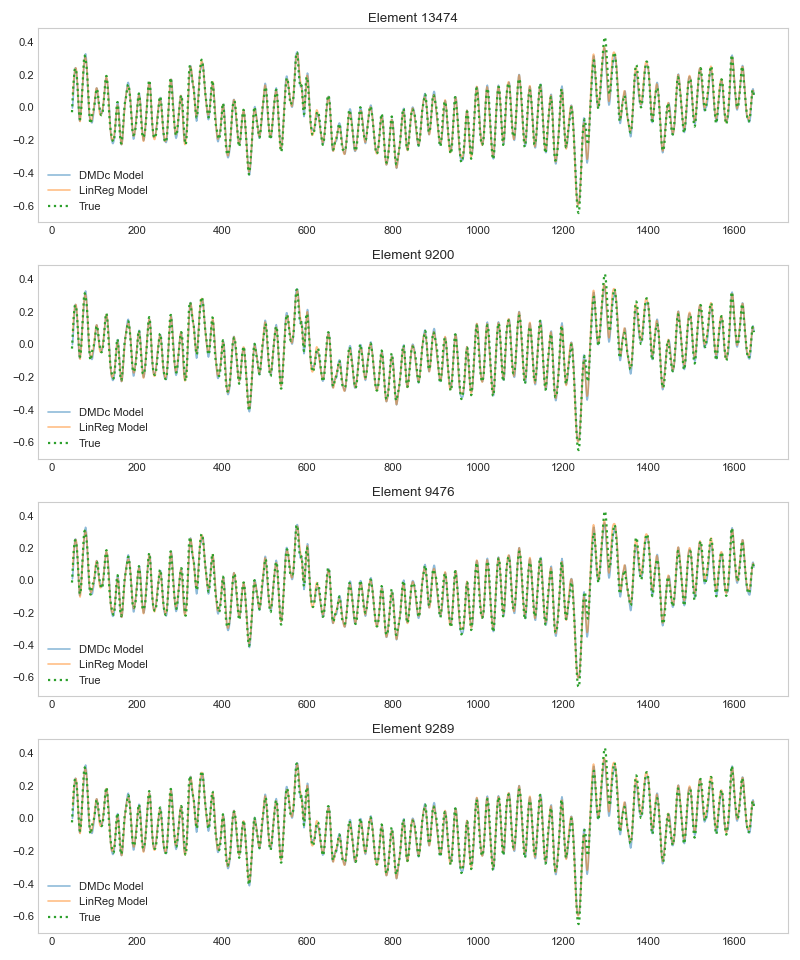

In [96]:


n = 4

fig2, axs2 = plt.subplots(nrows=n, ncols=1, figsize=(10,12))

axs2 = axs2.flatten()

for j, k in enumerate(worst_elems[:n]):
    
    k = int(k)
    
    axs2[j].set_title(f"Element {k}")
    axs2[j].plot(input_data.iloc[1:].index.values, dmd_preds[k, :], 
                 label="DMDc Model", alpha=0.5)
    
    axs2[j].plot(best_model.output_preds.iloc[:, k], 
                label="LinReg Model", alpha=0.5)
    
    axs2[j].plot(input_data.iloc[:, k], label="True", linestyle="dotted", linewidth=2)
    
    vx = input_data.iloc[100].name
    vy = [-1, 2]
    #axs2[j].plot([vx,vx], vy, color="k", linestyle="dashed", label="Train-Test-Split")
    
    #axs2[j].set_ylim([-0.5, 1.5])
    
    #axs2[j].set_yscale("symlog")
    
    axs2[j].grid("")
    axs2[j].legend()
    
    
plt.tight_layout()
plt.show()



In [132]:
best_model.regressor

LinearRegression()

## DMD Modes within PCA Projected Data

In [771]:
test_model = M.ReconModel("z", 100)
input_data = test_model.input_data

In [ ]:
input_data

In [773]:
test_data, _ = test_model.scale_n_proj("forward", input_data)
print(test_data.shape)

(1600, 100)


In [774]:
dmd_data = test_data.T
print(dmd_data)

           48         49          50          51          52          53    \
z_0   10.999541  52.854875   93.266915  130.577429  163.161047  189.287609   
z_1   76.011533  95.607725  115.418219  135.048553  152.352300  166.042238   
z_2   -9.785338  -4.146468   -1.753817   -2.347487   -2.221299    0.581633   
z_3   -8.484441  -8.557793   -9.167395   -9.269202   -9.211805   -8.725616   
z_4    5.414085   5.321177    3.394738    3.403322    6.001954    7.163552   
...         ...        ...         ...         ...         ...         ...   
z_95  -0.048002  -0.054685   -0.096443   -0.106068   -0.106550   -0.119715   
z_96  -0.007896   0.001831    0.013492    0.013716    0.024491    0.029723   
z_97   0.102657   0.146941    0.190357    0.249955    0.275497    0.288190   
z_98   0.012560   0.011645    0.011166    0.024403    0.013874    0.016101   
z_99  -0.007635  -0.008935   -0.005263    0.015424    0.025223    0.039919   

            54          55          56          57    ...      

In [790]:
def DMD(X, Xprime, r):
    
    # Step 1:
    U, Sigma, VT = np.linalg.svd(X, full_matrices=0)
    
    Ur = U[:, :r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r, :]
    
    # Step 2:
    Atilde = np.linalg.solve(Sigmar.T, (Ur.T @ Xprime @ VTr.T).T).T
    
    # Step 3:
    Lambda, W = np.linalg.eig(Atilde)
    #Lambda = np.diag(Lambda)
    
    # Extras:
    idx = Lambda.argsort()[::-1]
    Lambda = np.diag(Lambda[idx])
    W = W[:, idx]
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T, VTr).T @ W
    alpha1 = Sigmar @ VTr[:, 0]
    b = np.linalg.solve(W @ Lambda, alpha1)
    
    return Phi, Lambda, b



In [977]:
# We see that the Lambdas are now sorted correctly:
np.diag(Lambda.real)[np.argsort(np.diag(Lambda.real))[::-1]]

array([0.9196914 , 0.9196914 , 0.78942245, 0.78942245, 0.71826094,
       0.71826094, 0.5719076 , 0.5719076 , 0.27507055, 0.23093063],
      dtype=float32)

In [792]:
dmd_A = (dmd_data.iloc[:, :-1] @ np.linalg.pinv(dmd_data.iloc[:, 1:])) 
dmd_A

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
z_0,1.183273,0.004753,-0.804022,-0.672874,-0.689368,-3.713752,5.182945,-4.720808,7.929759,2.686444,...,-3.386401,9.514779,2.900679,-35.859022,16.473486,-17.936071,0.481042,17.491324,1.339618,-14.885375
z_1,0.008549,1.078770,0.282988,0.952816,-0.062763,-0.648833,-0.816079,1.012524,2.439354,-0.282049,...,34.843533,-16.824921,-4.537670,-6.441969,42.340148,10.814130,1.798030,-19.260893,13.179582,-3.559110
z_2,-0.000395,0.000892,0.896809,0.216114,-0.603601,0.172534,-1.019491,1.019088,0.051371,-0.304150,...,-13.918924,5.595789,-8.870564,-23.541871,6.487817,1.236487,-30.606881,-5.527201,-1.983624,-9.709811
z_3,-0.002197,0.017669,0.045808,1.017332,-0.165472,-0.142447,-0.268893,-0.221936,0.239444,0.329067,...,8.293313,-2.336652,5.159102,7.683013,0.373068,-1.222036,4.144250,9.059992,-1.685451,5.340635
z_4,0.020663,0.016184,-0.002603,0.051910,0.962671,-0.077744,-0.102362,0.065798,-0.329445,-0.296831,...,-0.431975,2.735594,5.468200,-0.613999,0.370121,-4.752978,-3.348811,4.959773,1.331383,-5.675145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z_95,-0.000167,-0.000808,-0.000422,-0.002261,-0.000950,0.001500,0.002340,-0.000351,-0.001235,-0.002128,...,-0.096040,0.077421,-0.029251,0.088267,0.007704,0.755688,-0.036005,0.006109,-0.058623,0.023261
z_96,-0.000165,-0.000015,0.000299,0.000657,-0.000932,-0.000380,-0.001651,0.000241,-0.000113,-0.001613,...,-0.017795,0.117491,0.058111,-0.073881,-0.017864,-0.023416,0.707576,-0.101855,-0.043098,-0.025544
z_97,-0.000267,0.000323,0.000922,0.002472,-0.000912,-0.002727,-0.004546,0.001331,0.005042,-0.001615,...,0.038895,-0.000962,-0.076946,0.119745,0.100917,-0.037288,0.037077,0.614067,0.016393,0.116936
z_98,-0.000173,0.000073,0.000102,0.000848,-0.000341,-0.000443,-0.000023,-0.000878,0.000421,0.001565,...,-0.029025,-0.082268,-0.040670,0.040259,-0.031087,-0.071239,0.010184,0.000292,0.653985,0.074428


<IPython.core.display.Javascript object>


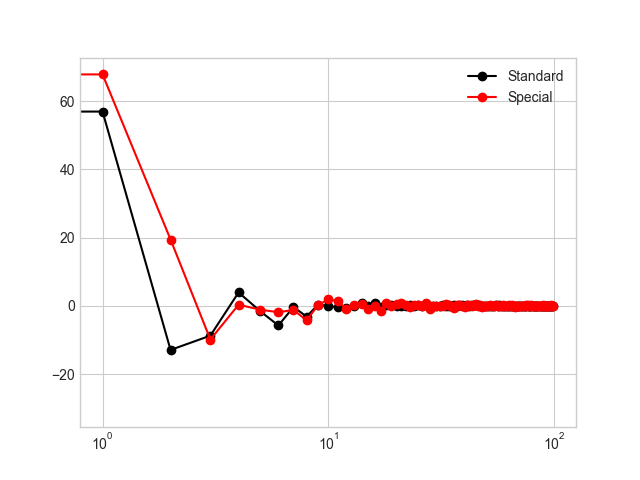

In [793]:
plt.figure()
plt.plot(dmd_A @ dmd_data.iloc[:, 0].values.reshape(-1,1), "-ko", label="Standard")
plt.plot(dmd_model_data.iloc[1,:].values.reshape(-1,1), "-ro", label="Special")
plt.xticks([])
plt.xscale("log")
plt.legend()
plt.show()

In [794]:
Phi, Lambda, b = DMD(dmd_data.iloc[:, :-1], dmd_data.iloc[:, 1:], 100)
Phi

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
z_0,-0.886460+0.000000j,-0.842039-0.126685j,-0.842039+0.126685j,0.718271-0.280155j,0.718271+0.280155j,-0.760334-0.164162j,-0.760334+0.164162j,0.847060+0.136939j,0.847060-0.136939j,0.921532+0.008046j,...,-0.012096-0.020064j,-0.012096+0.020064j,0.012924-0.028688j,0.012924+0.028688j,0.050331+0.000000j,-0.005514-0.046162j,-0.005514+0.046162j,0.108685-0.028052j,0.108685+0.028052j,-0.114573+0.000000j
z_1,-0.447653+0.000000j,0.299608+0.401780j,0.299608-0.401780j,-0.599578-0.095514j,-0.599578+0.095514j,-0.409139+0.422285j,-0.409139-0.422285j,0.305101-0.327032j,0.305101+0.327032j,0.265634+0.075484j,...,-0.061411-0.068993j,-0.061411+0.068993j,-0.101220+0.043331j,-0.101220-0.043331j,-0.098586+0.000000j,-0.098812-0.018993j,-0.098812+0.018993j,-0.056090-0.019806j,-0.056090+0.019806j,0.095612+0.000000j
z_2,-0.100600+0.000000j,-0.024265+0.011000j,-0.024265-0.011000j,-0.003337-0.011868j,-0.003337+0.011868j,-0.058092+0.034598j,-0.058092-0.034598j,0.065805-0.018869j,0.065805+0.018869j,0.076192+0.022103j,...,0.010741+0.021690j,0.010741-0.021690j,-0.030286+0.010559j,-0.030286-0.010559j,0.086410+0.000000j,-0.011477-0.113397j,-0.011477+0.113397j,0.111117-0.035927j,0.111117+0.035927j,-0.160978+0.000000j
z_3,0.017509+0.000000j,0.024688-0.003786j,0.024688+0.003786j,0.011307-0.000315j,0.011307+0.000315j,0.048994-0.023304j,0.048994+0.023304j,-0.042429+0.026788j,-0.042429-0.026788j,-0.050526-0.012466j,...,-0.067666+0.030586j,-0.067666-0.030586j,-0.014527+0.020241j,-0.014527-0.020241j,0.019023+0.000000j,0.020934-0.064218j,0.020934+0.064218j,-0.182806+0.020122j,-0.182806-0.020122j,0.051076+0.000000j
z_4,0.002315+0.000000j,0.005011+0.014756j,0.005011-0.014756j,0.007355-0.001174j,0.007355+0.001174j,-0.010607+0.000547j,-0.010607-0.000547j,0.009559-0.001006j,0.009559+0.001006j,0.001187+0.006781j,...,-0.008775-0.173420j,-0.008775+0.173420j,-0.004180-0.001079j,-0.004180+0.001079j,-0.030321+0.000000j,-0.058690-0.160530j,-0.058690+0.160530j,0.131574+0.044766j,0.131574-0.044766j,-0.142431+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z_95,0.000158+0.000000j,-0.000163-0.000262j,-0.000163+0.000262j,0.000197+0.000124j,0.000197-0.000124j,0.000256-0.000151j,0.000256+0.000151j,-0.000228+0.000052j,-0.000228-0.000052j,-0.000258-0.000185j,...,-0.002056-0.000939j,-0.002056+0.000939j,0.001304-0.000744j,0.001304+0.000744j,0.000107+0.000000j,-0.001798+0.001922j,-0.001798-0.001922j,-0.001093-0.000026j,-0.001093+0.000026j,-0.008551+0.000000j
z_96,0.000040+0.000000j,0.000135+0.000098j,0.000135-0.000098j,-0.000083+0.000060j,-0.000083-0.000060j,0.000004+0.000101j,0.000004-0.000101j,-0.000020-0.000089j,-0.000020+0.000089j,-0.000019+0.000020j,...,-0.001567-0.001334j,-0.001567+0.001334j,0.000782-0.000871j,0.000782+0.000871j,0.001601+0.000000j,0.000831+0.001865j,0.000831-0.001865j,-0.000744+0.000745j,-0.000744-0.000745j,-0.001771+0.000000j
z_97,-0.000844+0.000000j,0.000433+0.000654j,0.000433-0.000654j,-0.000770-0.000176j,-0.000770+0.000176j,-0.000671+0.000619j,-0.000671-0.000619j,0.000522-0.000448j,0.000522+0.000448j,0.000406+0.000105j,...,0.001786-0.000368j,0.001786+0.000368j,-0.000080+0.000266j,-0.000080-0.000266j,-0.000418+0.000000j,-0.000539+0.002875j,-0.000539-0.002875j,-0.002617-0.001685j,-0.002617+0.001685j,-0.004169+0.000000j
z_98,-0.000340+0.000000j,0.000264+0.000151j,0.000264-0.000151j,-0.000420-0.000018j,-0.000420+0.000018j,-0.000024+0.000182j,-0.000024-0.000182j,-0.000044-0.000148j,-0.000044+0.000148j,-0.000014+0.000033j,...,-0.000151-0.001333j,-0.000151+0.001333j,0.000469-0.000823j,0.000469+0.000823j,0.003503+0.000000j,0.001699-0.003526j,0.001699+0.003526j,-0.001593-0.001820j,-0.001593+0.001820j,-0.001498+0.000000j


In [795]:
dmd_model_data

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,...,z_90,z_91,z_92,z_93,z_94,z_95,z_96,z_97,z_98,z_99
48,-11.629433,66.080043,18.941580,-9.987131,0.896773,-0.649850,-1.385305,-2.293616,-3.826525,0.419778,...,0.040539,-0.035573,-0.074928,-0.001529,0.046333,-0.058598,0.012329,0.156811,0.016162,0.010190
49,10.294033,67.815134,19.413969,-9.877995,0.314989,-1.143483,-1.891223,-1.210904,-4.273967,0.228201,...,0.028538,-0.014402,-0.074001,0.011218,0.055709,-0.068677,0.012994,0.160836,0.012592,0.014185
50,30.037665,68.268243,19.619526,-9.859362,0.257670,-1.727219,-2.048904,-0.577667,-4.536052,0.231089,...,0.022942,-0.009109,-0.067132,0.016869,0.070430,-0.067236,0.013799,0.161955,0.011463,0.020029
51,47.288865,67.828573,19.404291,-9.841208,0.258016,-2.050342,-2.161161,0.021314,-4.694836,0.177836,...,0.019645,0.003867,-0.065614,0.023551,0.072047,-0.070000,0.011889,0.156261,0.007441,0.024189
52,62.324234,66.584386,19.077988,-9.831286,0.365169,-2.400406,-2.216040,0.430437,-4.777250,0.230422,...,0.018760,0.008032,-0.060205,0.027306,0.077387,-0.067330,0.010682,0.150938,0.004105,0.028773
53,75.249374,64.830438,18.581324,-9.791452,0.433128,-2.625943,-2.259482,0.800002,-4.824116,0.231100,...,0.018309,0.015544,-0.057471,0.031614,0.077177,-0.066990,0.008738,0.143261,0.000263,0.032027
54,86.335955,62.673850,18.048995,-9.743071,0.525705,-2.840874,-2.283411,1.070301,-4.830589,0.276576,...,0.018757,0.018699,-0.053052,0.034308,0.078775,-0.064224,0.007241,0.136259,-0.002951,0.035293
55,95.741872,60.276994,17.448159,-9.671612,0.585115,-2.982203,-2.299646,1.309321,-4.816306,0.292621,...,0.019273,0.023247,-0.050055,0.037043,0.077758,-0.062639,0.005495,0.128463,-0.006144,0.037767
56,103.684497,57.706988,16.841605,-9.590541,0.648060,-3.103188,-2.304168,1.491110,-4.777818,0.327202,...,0.020144,0.025581,-0.046399,0.038806,0.077515,-0.059951,0.004030,0.121223,-0.008864,0.040105
57,110.314223,55.050859,16.213915,-9.494028,0.689606,-3.178000,-2.301857,1.648302,-4.725427,0.345968,...,0.020991,0.028416,-0.043526,0.040409,0.075985,-0.057847,0.002521,0.113826,-0.011415,0.041937


In [796]:
print(Phi.values.shape, Lambda.shape, b.shape)

dmd_list = []
for i in tqdm(range(1, 60)):
    dmd_list.append(Phi.values.real @ Lambda.real**i @ b.real)

(100, 100) (100, 100) (100,)


100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 627.75it/s]


In [797]:
dmd_model_data = pd.DataFrame(np.array(dmd_list), columns=test_data.columns,
                             index=input_data.index[:i])

In [798]:
dmd_model_data, _ = test_model.scale_n_proj("inverse", dmd_model_data)

In [799]:
print(input_data.shape)
print(dmd_model_data.shape)

something = np.mean(mf.rmse(input_data.iloc[1:60].values, dmd_model_data.values, axis=1))
print(something)

(1600, 17980)
(59, 17980)
0.16365968805668313


<IPython.core.display.Javascript object>


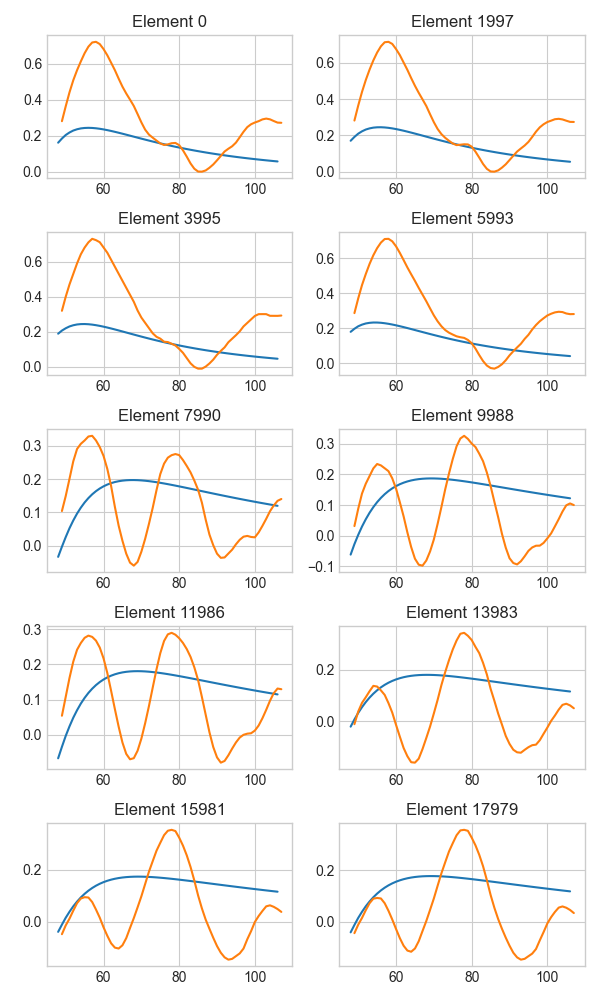

In [800]:
n = 10

fig, axs = plt.subplots(5,2, figsize=(6, 10))

axs = axs.flatten()

for j, k in enumerate(np.linspace(0, 17980-1, n)):
    k = int(k)
    axs[j].set_title(f"Element {k}")
    axs[j].plot((dmd_model_data.iloc[:,k]), label="Model")
    axs[j].plot(input_data.iloc[1:60, k], label="True")

fig.tight_layout()
plt.show()

In [801]:
Phi2 = Phi.values[:].real
Phi3 = pd.DataFrame(Phi2, columns = test_data.columns)
Phi3

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,...,z_90,z_91,z_92,z_93,z_94,z_95,z_96,z_97,z_98,z_99
0,-0.886460,-0.842039,-0.842039,0.718271,0.718271,-0.760334,-0.760334,0.847060,0.847060,0.921532,...,-0.012096,-0.012096,0.012924,0.012924,0.050331,-0.005514,-0.005514,0.108685,0.108685,-0.114573
1,-0.447653,0.299608,0.299608,-0.599578,-0.599578,-0.409139,-0.409139,0.305101,0.305101,0.265634,...,-0.061411,-0.061411,-0.101220,-0.101220,-0.098586,-0.098812,-0.098812,-0.056090,-0.056090,0.095612
2,-0.100600,-0.024265,-0.024265,-0.003337,-0.003337,-0.058092,-0.058092,0.065805,0.065805,0.076192,...,0.010741,0.010741,-0.030286,-0.030286,0.086410,-0.011477,-0.011477,0.111117,0.111117,-0.160978
3,0.017509,0.024688,0.024688,0.011307,0.011307,0.048994,0.048994,-0.042429,-0.042429,-0.050526,...,-0.067666,-0.067666,-0.014527,-0.014527,0.019023,0.020934,0.020934,-0.182806,-0.182806,0.051076
4,0.002315,0.005011,0.005011,0.007355,0.007355,-0.010607,-0.010607,0.009559,0.009559,0.001187,...,-0.008775,-0.008775,-0.004180,-0.004180,-0.030321,-0.058690,-0.058690,0.131574,0.131574,-0.142431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000158,-0.000163,-0.000163,0.000197,0.000197,0.000256,0.000256,-0.000228,-0.000228,-0.000258,...,-0.002056,-0.002056,0.001304,0.001304,0.000107,-0.001798,-0.001798,-0.001093,-0.001093,-0.008551
96,0.000040,0.000135,0.000135,-0.000083,-0.000083,0.000004,0.000004,-0.000020,-0.000020,-0.000019,...,-0.001567,-0.001567,0.000782,0.000782,0.001601,0.000831,0.000831,-0.000744,-0.000744,-0.001771
97,-0.000844,0.000433,0.000433,-0.000770,-0.000770,-0.000671,-0.000671,0.000522,0.000522,0.000406,...,0.001786,0.001786,-0.000080,-0.000080,-0.000418,-0.000539,-0.000539,-0.002617,-0.002617,-0.004169
98,-0.000340,0.000264,0.000264,-0.000420,-0.000420,-0.000024,-0.000024,-0.000044,-0.000044,-0.000014,...,-0.000151,-0.000151,0.000469,0.000469,0.003503,0.001699,0.001699,-0.001593,-0.001593,-0.001498


In [802]:
mode_data, _ = test_model.scale_n_proj("inverse", Phi3)
mode_data

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,...,z_17970,z_17971,z_17972,z_17973,z_17974,z_17975,z_17976,z_17977,z_17978,z_17979
0,0.007341,7.388136e-03,6.755900e-03,6.991938e-03,0.005635,5.583899e-03,0.004899,5.609728e-03,4.778361e-03,5.214851e-03,...,-0.000289,-0.001668,0.001125,-0.007059,-0.004820,-0.000545,-0.001438,-6.799610e-03,-0.001750,-0.003774
1,0.011109,1.108525e-02,1.090898e-02,1.100245e-02,0.010251,1.079140e-02,0.010027,1.079707e-02,1.022877e-02,1.078386e-02,...,-0.004874,-0.002516,-0.004664,-0.003515,-0.003569,-0.005432,-0.004954,-4.787318e-03,-0.005694,-0.005689
2,0.002033,2.195849e-03,1.976575e-03,2.004444e-03,0.001704,1.925863e-03,0.001663,2.020032e-03,1.725739e-03,2.023255e-03,...,0.001918,0.000559,0.001855,0.000105,0.000242,0.001606,0.001720,2.967381e-04,0.001371,0.001365
3,0.000603,6.675372e-04,6.834339e-04,7.339325e-04,0.000667,6.287394e-04,0.000638,6.315825e-04,6.295414e-04,5.608613e-04,...,0.000559,0.001286,0.000393,0.001341,0.001241,0.000366,0.000717,1.003166e-03,0.000540,0.000704
4,-0.000376,-2.652933e-04,-3.177244e-04,-3.753889e-04,-0.000276,-2.812010e-04,-0.000251,-2.922496e-04,-2.362715e-04,-2.679653e-04,...,-0.000474,-0.000163,-0.000107,0.000075,0.000069,-0.000087,-0.000482,1.833817e-04,-0.000136,-0.000406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000014,2.369781e-05,2.004322e-05,1.924852e-05,0.000019,1.886975e-05,0.000019,1.947493e-05,1.918695e-05,1.793670e-05,...,-0.000002,-0.000007,-0.000007,-0.000002,-0.000004,-0.000001,-0.000006,-1.995315e-07,-0.000008,-0.000011
96,0.000010,1.228835e-05,1.165212e-05,1.141118e-05,0.000010,1.083955e-05,0.000010,1.100655e-05,1.008195e-05,1.052891e-05,...,-0.000002,-0.000005,-0.000007,-0.000006,-0.000005,-0.000005,-0.000005,-3.105327e-06,-0.000009,-0.000006
97,0.000021,2.329957e-05,2.157171e-05,2.184420e-05,0.000020,2.188435e-05,0.000020,2.211505e-05,2.017814e-05,2.101220e-05,...,0.000005,-0.000011,-0.000007,-0.000015,-0.000015,-0.000002,0.000003,-1.393555e-05,-0.000004,-0.000006
98,-0.000002,-7.209167e-07,-6.992582e-07,2.881079e-07,-0.000002,1.628937e-06,-0.000001,2.263421e-06,8.056390e-09,2.570822e-06,...,-0.000007,-0.000016,-0.000021,-0.000022,-0.000020,-0.000013,-0.000010,-1.621706e-05,-0.000017,-0.000013


In [803]:
img_data = mf.get_mikeio_format()

In [804]:
img_data.values

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

<IPython.core.display.Javascript object>


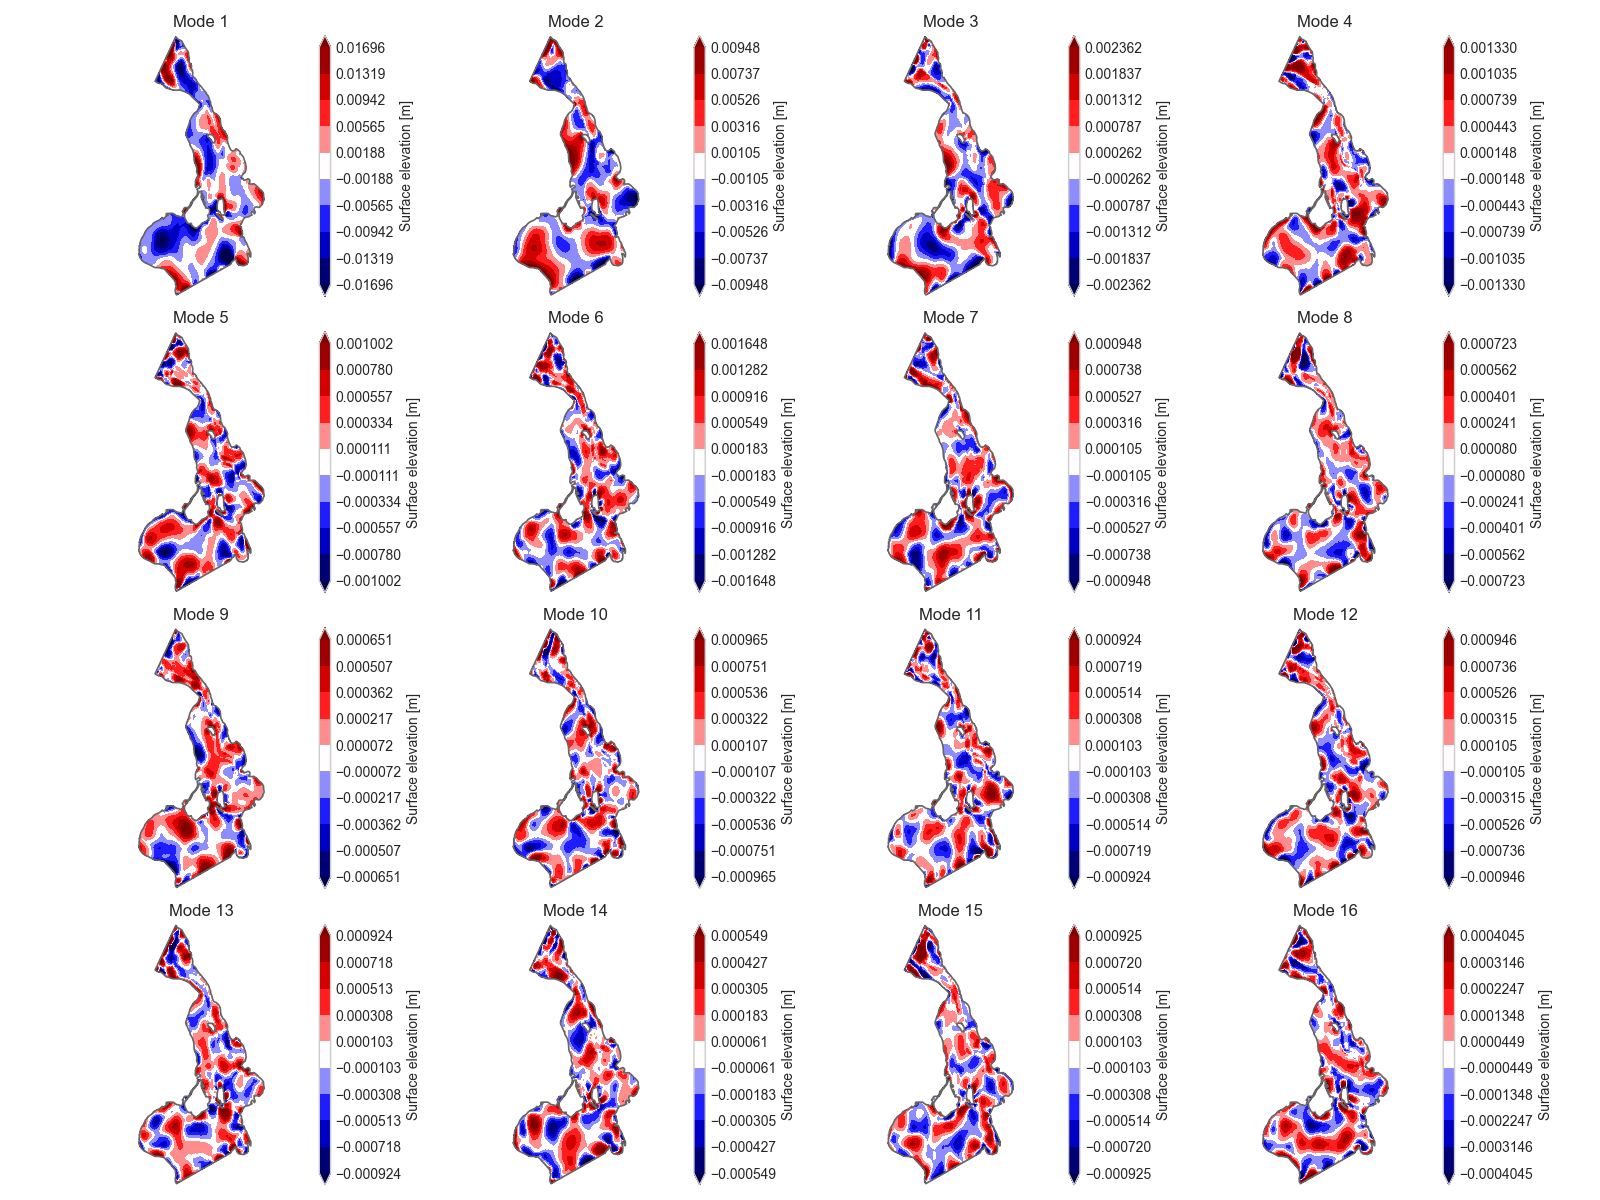

In [805]:
# Create 4-by-4 subplots:
fig, ax = plt.subplots(4, 4, figsize=(16, 12))

# Loop over all subplots:
for i in range(4):
    for j in range(4):
        
        # Plot data:
        img_data.values = mode_data.iloc[4*i + j].values
        
        v_max = np.quantile(np.abs(img_data.values), 0.95)
        v_min = -v_max
        
        img_data.plot.contourf(ax=ax[i, j], cmap="seismic", vmin=v_min, vmax=v_max)
        
        # Set title:
        ax[i, j].set_title(f"Mode {4*i + j + 1}")
        
        # Remove axis:
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()


In [806]:
# Save figure:
fig.savefig("../Figures/Exp_13_DMD_modes_rel.png", dpi=100)

<IPython.core.display.Javascript object>


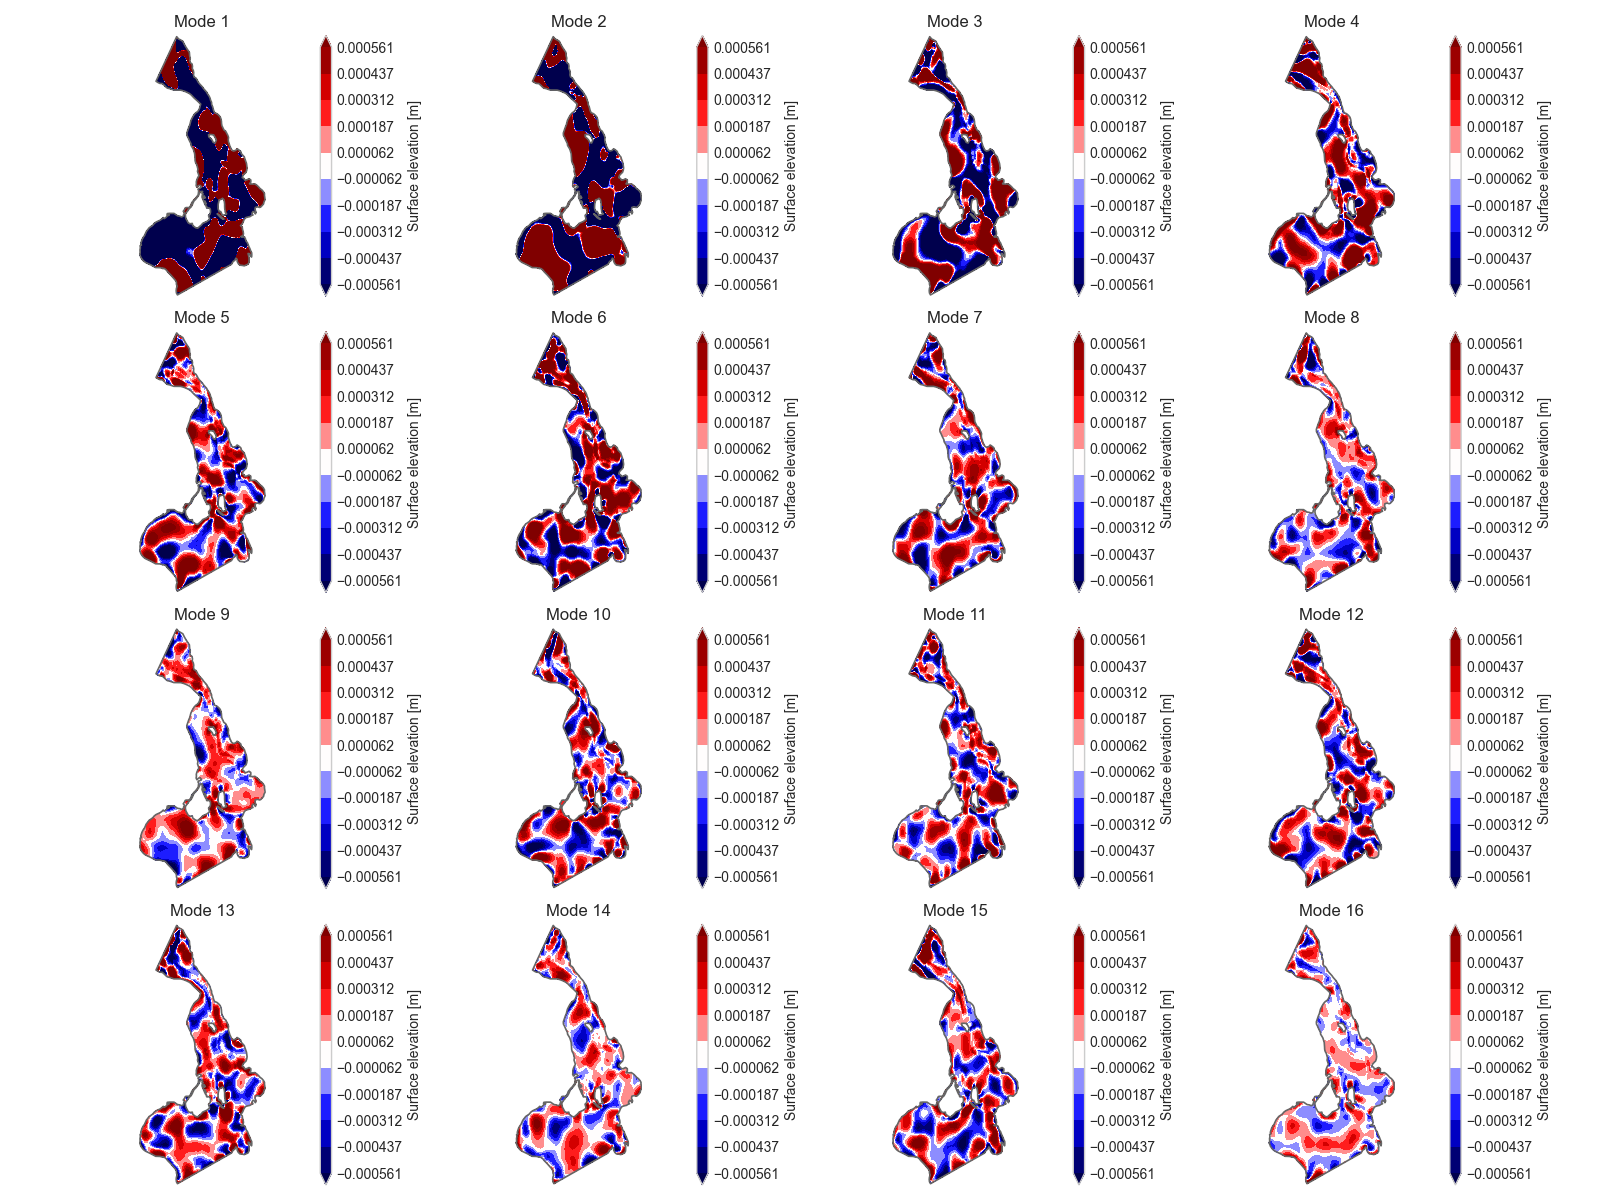

In [807]:
# Create 4-by-4 subplots:
fig2, ax = plt.subplots(4, 4, figsize=(16, 12))

v_max = np.quantile(np.abs(mode_data), 0.95)
v_min = -v_max

# Loop over all subplots:
for i in range(4):
    for j in range(4):
        
        # Plot data:
        img_data.values = mode_data.iloc[4*i + j].values
        img_data.plot.contourf(ax=ax[i, j], cmap="seismic", vmin=v_min, vmax=v_max)
        
        # Set title:
        ax[i, j].set_title(f"Mode {4*i + j + 1}")
        
        # Remove axis:
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()


In [808]:
# Save figure:
fig2.savefig("../Figures/Exp_13_DMD_modes_abs.png", dpi=100)

0.0019415166701868825

<IPython.core.display.Javascript object>


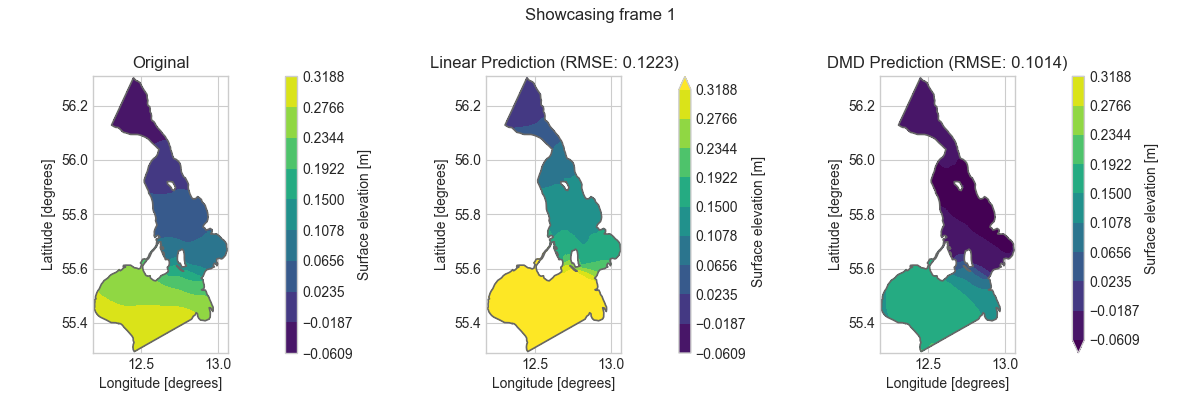

In [810]:

test_frame = 1

Xtest, _ = test_model.scale_n_proj("inverse", pd.DataFrame(Phi3 @ Lambda.real**(test_frame) @ b.real).T)

fig, ax = plt.subplots(figsize=(12,4), ncols=3, nrows=1)

fig.suptitle(f"Showcasing frame {test_frame}\n")

img_data.values[:] = data.values[test_frame]

cmap_max = img_data.values.max()
cmap_min = img_data.values.min()



img_data.plot.contourf(ax=ax[0])

ax[0].set_title("Original")

img_data.values[:] = pred.values[test_frame]
img_data.plot.contourf(ax=ax[1], vmin=cmap_min, vmax=cmap_max)

rmse = mf.rmse(data.values[test_frame], img_data.values, axis=0)
        
ax[1].set_title(f"Linear Prediction (RMSE: {rmse.mean():.4f})")

img_data.values[:] = Xtest.values
img_data.plot.contourf(ax=ax[2], vmin=cmap_min, vmax=cmap_max)

rmse = mf.rmse(data.values[test_frame], img_data.values, axis=0)
        
ax[2].set_title(f"DMD Prediction (RMSE: {rmse.mean():.4f})")

fig.tight_layout()

plt.show()


<IPython.core.display.Javascript object>


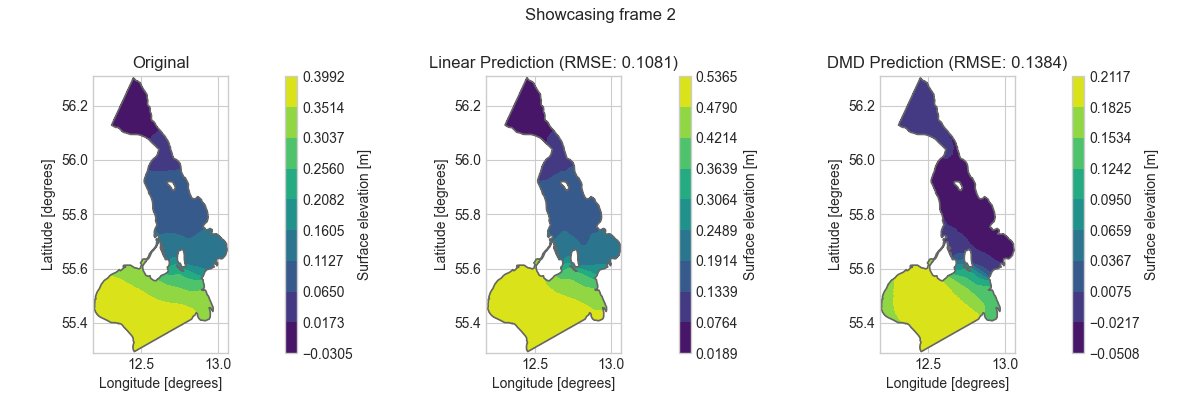

In [811]:

test_frame = 2

Xtest, _ = test_model.scale_n_proj("inverse", pd.DataFrame(Phi3 @ Lambda.real**(test_frame) @ b.real).T)

fig, ax = plt.subplots(figsize=(12,4), ncols=3, nrows=1)

fig.suptitle(f"Showcasing frame {test_frame}\n")

img_data.values[:] = data.values[test_frame]
img_data.plot.contourf(ax=ax[0])

ax[0].set_title("Original")

img_data.values[:] = pred.values[test_frame]
img_data.plot.contourf(ax=ax[1])

rmse = mf.rmse(data.values[test_frame], img_data.values, axis=0)
        
ax[1].set_title(f"Linear Prediction (RMSE: {rmse.mean():.4f})")

img_data.values[:] = Xtest.values
img_data.plot.contourf(ax=ax[2])

rmse = mf.rmse(data.values[test_frame], img_data.values, axis=0)
        
ax[2].set_title(f"DMD Prediction (RMSE: {rmse.mean():.4f})")

fig.tight_layout()

plt.show()


<IPython.core.display.Javascript object>


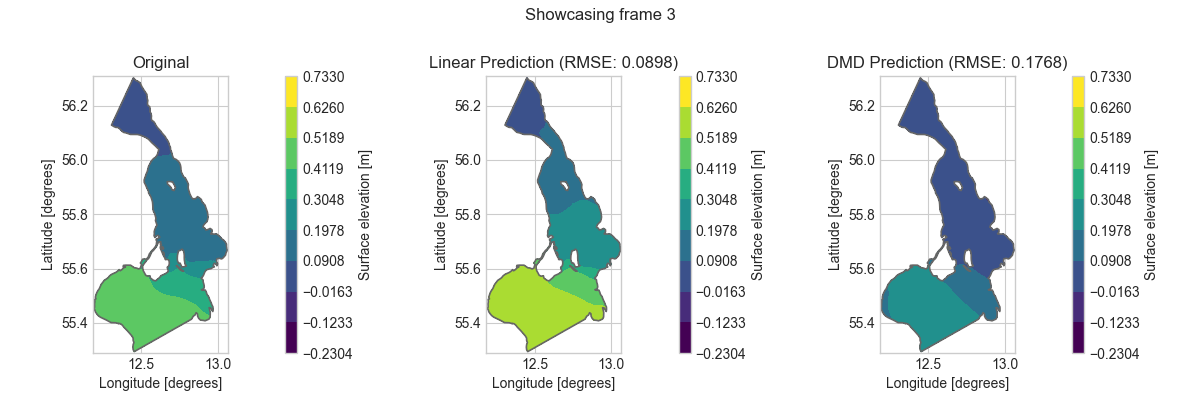

In [812]:

test_frame = 3

Xtest, _ = test_model.scale_n_proj("inverse", pd.DataFrame(Phi3 @ Lambda.real**(test_frame) @ b.real).T)

fig, ax = plt.subplots(figsize=(12,4), ncols=3, nrows=1)

fig.suptitle(f"Showcasing frame {test_frame}\n")

lvls = np.linspace(data.values.min(), data.values.max(), 10)

img_data.values[:] = data.values[test_frame]
img_data.plot.contourf(ax=ax[0], levels=lvls)

ax[0].set_title("Original")

img_data.values[:] = pred.values[test_frame]
img_data.plot.contourf(ax=ax[1], levels=lvls)

rmse = mf.rmse(data.values[test_frame], img_data.values, axis=0)
        
ax[1].set_title(f"Linear Prediction (RMSE: {rmse.mean():.4f})")

img_data.values[:] = Xtest.values
img_data.plot.contourf(ax=ax[2], levels=lvls)

rmse = mf.rmse(data.values[test_frame], img_data.values, axis=0)
        
ax[2].set_title(f"DMD Prediction (RMSE: {rmse.mean():.4f})")

fig.tight_layout()

plt.show()
